Epoch [1/5], Train Loss: 0.4330, Train Accuracy: 84.90%, Validation Loss: 0.0951, Validation Accuracy: 96.30%, F1 Score: 96.24%, Precision: 96.87%, Recall: 96.30%
Epoch [2/5], Train Loss: 0.0682, Train Accuracy: 97.88%, Validation Loss: 0.0923, Validation Accuracy: 96.50%, F1 Score: 96.46%, Precision: 96.86%, Recall: 96.50%
Epoch [3/5], Train Loss: 0.0482, Train Accuracy: 98.20%, Validation Loss: 0.0826, Validation Accuracy: 97.20%, F1 Score: 97.16%, Precision: 97.42%, Recall: 97.20%
Epoch [4/5], Train Loss: 0.0285, Train Accuracy: 99.03%, Validation Loss: 0.0233, Validation Accuracy: 99.10%, F1 Score: 99.10%, Precision: 99.11%, Recall: 99.10%
Epoch [5/5], Train Loss: 0.0063, Train Accuracy: 99.85%, Validation Loss: 0.0100, Validation Accuracy: 99.80%, F1 Score: 99.80%, Precision: 99.80%, Recall: 99.80%


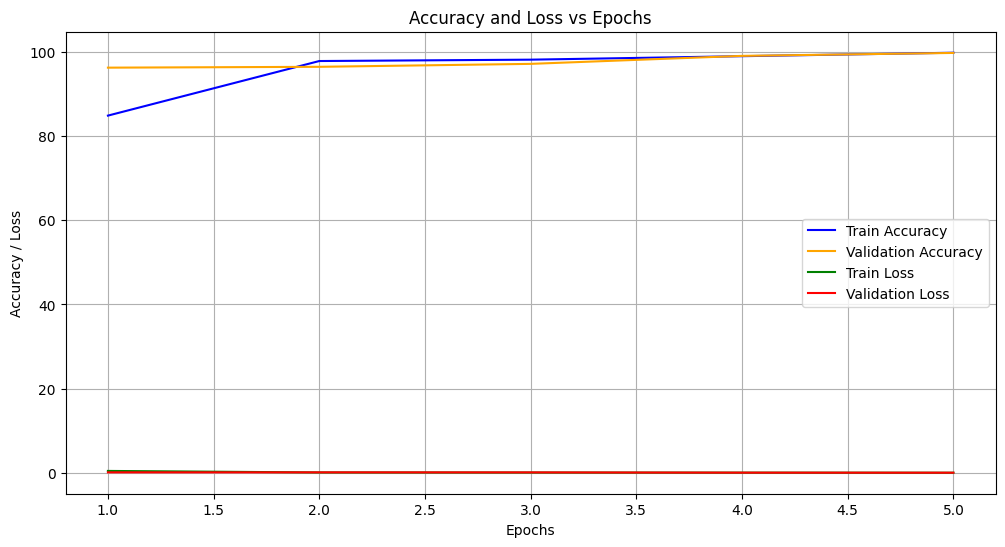

Best model saved to /kaggle/working/swine_s_model.pth with validation accuracy: 99.80%
Best F1 Score: 99.80% at Epoch 5
Best Precision: 99.80% at Epoch 5
Best Recall: 99.80% at Epoch 5


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data preprocessing
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset and DataLoader setup
train_dataset = datasets.ImageFolder('/kaggle/input/datasetmosquito/dataset/dataset/trainset', transform=train_transform)
test_dataset = datasets.ImageFolder('/kaggle/input/datasetmosquito/dataset/dataset/testset', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model setup using Swin Transformer Small
model = create_model('swin_small_patch4_window7_224', num_classes=10, pretrained=True).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training and evaluation
num_epochs = 5
train_losses = []
train_accuracies = []
val_accuracies = []
val_losses = []
val_f1_scores = []
val_precisions = []
val_recalls = []

best_val_accuracy = 0.0
best_model_path = '/kaggle/working/swin_s_model.pth'

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss /= len(train_loader)
    train_accuracy = 100 * correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    all_preds = []
    all_labels = []
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_accuracy = accuracy_score(all_labels, all_preds) * 100
    val_loss /= len(test_loader)

    f1 = f1_score(all_labels, all_preds, average='macro') * 100
    precision = precision_score(all_labels, all_preds, average='macro') * 100
    recall = recall_score(all_labels, all_preds, average='macro') * 100

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)

    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)
    val_f1_scores.append(f1)
    val_precisions.append(precision)
    val_recalls.append(recall)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.2f}%, '
          f'F1 Score: {f1:.2f}%, '
          f'Precision: {precision:.2f}%, '
          f'Recall: {recall:.2f}%')

# Plotting accuracy and loss against epochs
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='green')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.title('Accuracy and Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

best_f1_index = np.argmax(val_f1_scores)
best_precision_index = np.argmax(val_precisions)
best_recall_index = np.argmax(val_recalls)

print(f'Best model saved to {best_model_path} with validation accuracy: {best_val_accuracy:.2f}%')
print(f'Best F1 Score: {val_f1_scores[best_f1_index]:.2f}% at Epoch {best_f1_index + 1}')
print(f'Best Precision: {val_precisions[best_precision_index]:.2f}% at Epoch {best_precision_index + 1}')
print(f'Best Recall: {val_recalls[best_recall_index]:.2f}% at Epoch {best_recall_index + 1}')


In [1]:
import torch
from timm import create_model

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model setup using Swin Transformer Small
model = create_model('swin_small_patch4_window7_224', num_classes=10, pretrained=True).to(device)

# Counting the number of parameters
total_params = sum(p.numel() for p in model.parameters())
params_in_millions = total_params / 1_000_000

print(f'Number of parameters in the model: {params_in_millions:.2f} million')


model.safetensors:   0%|          | 0.00/200M [00:00<?, ?B/s]

Number of parameters in the model: 48.84 million


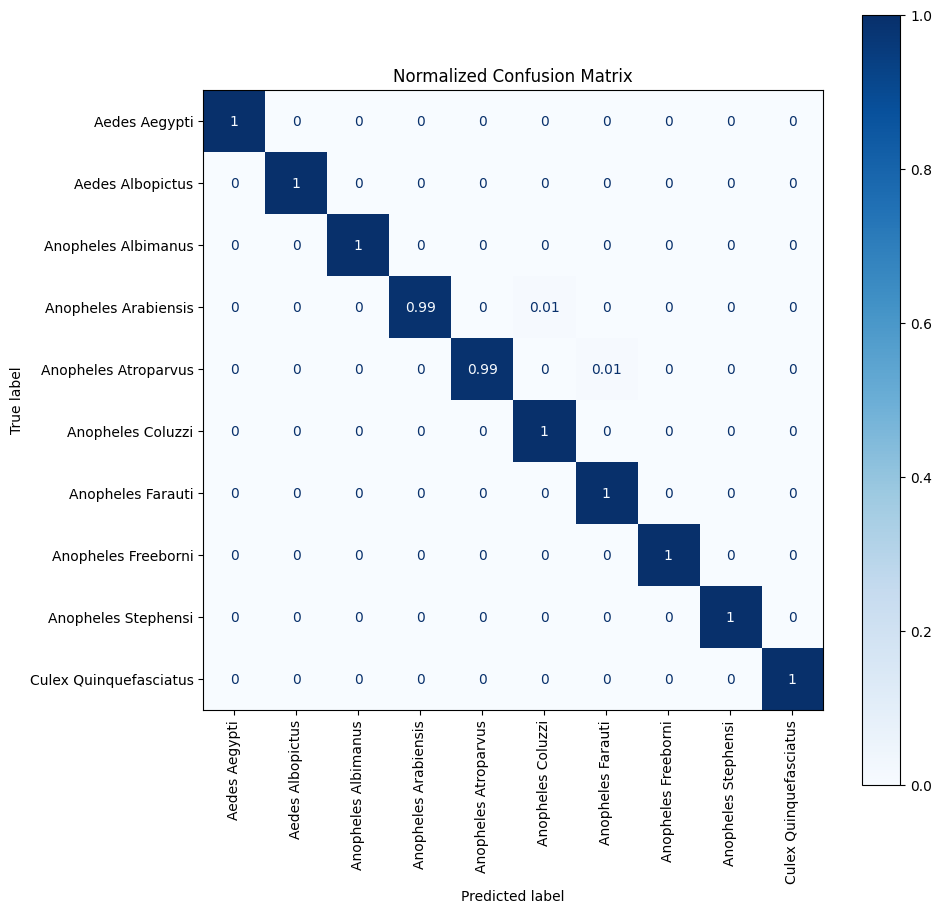

In [7]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming the completion of the training and validation phase
# and you have `all_labels` and `all_preds`

# Define class names manually based on your dataset
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus',
               'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi',
               'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi',
               'Culex Quinquefasciatus']

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_preds, normalize='true')

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title('Normalized Confusion Matrix')
plt.show()
